# Intelligent Bookmark Organization Using Hierarchical Clustering

## Introduction: The Problem

### The Challenge of Digital Organization
Modern internet users collect hundreds of bookmarks across various topics—learning resources, career tools, entertainment sites, and utilities. Without organization, these bookmarks become a digital junkyard where finding anything requires scrolling through endless lists or using browser search.

**Manual folder organization is time-consuming and inconsistent:**
- Users must decide folder names and hierarchy upfront
- Categorization is subjective and changes over time  
- New bookmarks often get saved to generic "Other" folders
- Similar content gets scattered across multiple folders

### My Solution: Automated Clustering

**Research Question:** Can we automatically organize bookmarks into meaningful thematic folders using unsupervised machine learning?

**Specific Goals:**
1. Group semantically similar bookmarks together without manual labeling
2. Determine the optimal number of folders (clusters) for usability
3. Generate human-readable folder names that describe each cluster's theme
4. Handle diverse bookmark collections (learning, entertainment, tools, career resources)

**Why Clustering?**
Unlike supervised learning (which requires labeled training data), clustering discovers hidden patterns in unlabeled data—perfect for personal bookmark collections where no predefined categories exist. We'll use **Agglomerative Hierarchical Clustering** to group bookmarks based on semantic similarity of their descriptions.

### Project Scope

We'll analyze **256 personal bookmarks** spanning technical interview prep, online courses, entertainment streaming sites, productivity tools, and more. The clustering algorithm will organize these into 8-15 thematic folders, mimicking how users naturally group related content.

## What is Clustering and How Does It Work?

### Clustering Fundamentals

**Clustering** is an unsupervised machine learning technique that groups similar data points together without predefined labels. Unlike classification (which assigns data to known categories), clustering *discovers* natural groupings in the data.

**Key Concept:** Objects in the same cluster should be more similar to each other than to objects in other clusters.

### Agglomerative Hierarchical Clustering

We chose **Agglomerative Hierarchical Clustering** for this project. Here's how it works:

#### The Algorithm (Bottom-Up Approach)

1. **Start:** Each bookmark is its own cluster (N clusters for N bookmarks)
2. **Merge:** Repeatedly combine the two most similar clusters
3. **Continue:** Until we reach the desired number of clusters (N)
4. **Output:** A hierarchy (dendrogram) showing how clusters merge

#### Why Agglomerative Over K-Means?

| Aspect | K-Means | Agglomerative |
|--------|---------|---------------|
| **Cluster Shape** | Assumes spherical clusters | Handles arbitrary shapes |
| **Sensitivity** | Sensitive to initialization | Deterministic (same result every time) |
| **Hierarchy** | No hierarchy | Creates dendrogram showing relationships |
| **Small Clusters** | Struggles with very small clusters | Handles uneven cluster sizes |

**For bookmark organization**, Agglomerative is superior because:
- Some topics (interview prep) have many bookmarks, others (specific tools) have few
- We want consistent results every time the algorithm runs
- Hierarchical relationships make sense (e.g., "Career Resources" → "Interview Prep" → "LeetCode Questions")

#### Linkage Method: Ward's Criterion

We use **Ward linkage**, which minimizes the variance within clusters. At each merge step, Ward's method combines the two clusters that increase total intra-cluster variance the least.

**Formula:** Ward minimizes:
$$\sum_{i=1}^{k} \sum_{x \in C_i} ||x - \mu_i||^2$$

Where $C_i$ is cluster $i$ and $\mu_i$ is its centroid.

This produces compact, well-separated clusters—ideal for creating distinct bookmark folders.

#### Distance Metric: Euclidean Distance

After converting bookmark descriptions to 384-dimensional embedding vectors (using sentence transformers), we measure similarity using **Euclidean distance**:

$$d(x, y) = \sqrt{\sum_{i=1}^{384} (x_i - y_i)^2}$$

Bookmarks with similar semantic meaning will have small distances in embedding space.

In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import os
import dotenv

## The Dataset: Personal Bookmark Collection

### Data Source

**Primary Data:** 256 bookmarks exported from Google Chrome browser
- **Collection Period:** Accumulated over 2+ years of academic and personal use
- **Export Method:** Chrome Bookmark Manager → Export bookmarks → HTML file
- **Processing:** Custom Python scraper to extract URL metadata

### Data Collection Process

For each bookmark URL, we extracted:

1. **Title:** Original bookmark title from browser
2. **URL:** Full web address
3. **Description:** Extracted from HTML metadata tags in priority order:
   - `<meta name="description">` (preferred—author-written summaries)
   - `<meta property="og:description">` (Open Graph social media descriptions)
   - `<meta name="twitter:description">` (Twitter card descriptions)  
   - First 400 characters of `<body>` text (fallback)

4. **Content Type:** MIME type (text/html, application/pdf, etc.)
5. **Description Source:** Which metadata tag was used

### Dataset Features

| Feature | Description | Example |
|---------|-------------|---------|
| `title` | Bookmark name | "LeetCode - The World's Leading Online Programming..." |
| `url` | Web address | https://leetcode.com/ |
| `description` | Text summary of page content | "Level up your coding skills and quickly land a job..." |
| `description_source` | Where description came from | "meta", "og", "body", "unknown" |
| `content_type` | Page format | "text/html; charset=utf-8" |
| `html_length` | Size of HTML content | 150823 |

### Why This Data is Suitable for Clustering

1. **Rich semantic content:** Descriptions contain thematic keywords
2. **Natural diversity:** Mix of learning platforms, tools, entertainment, career resources
3. **No predefined labels:** Perfect for unsupervised learning
4. **Real-world messiness:** Includes PDFs, local files, dead links—mimics actual bookmark collections
5. **Personal relevance:** Reflects genuine user interests and organization challenges

**Dataset Link:** [Will be hosted on GitHub]

In [121]:
df = pd.read_csv('mined_preview.csv')

In [122]:
df.head(10)

,title,url,description_source,description,meta_description,og_description,twitter_description,body_snippet,html_length,content_type
0,@lc-holy - Miraculous & Spy x Family AUs,https://www.tumblr.com/lc-holy,meta,French artist | You can repost/translate my c...,French artist | You can repost/translate my c...,French artist | You can repost/translate my c...,NaN,Explore Communities Change palette Sign up Log...,556703,text/html; charset=utf-8
1,9anime - Watch Anime online with DUB and SUB f...,https://9animetv.to/,meta,9anime is the best free anime streaming websit...,9anime is the best free anime streaming websit...,9anime is the best free anime streaming websit...,NaN,Home Genres Action Adventure Cars Comedy Demen...,95718,text/html; charset=utf-8
2,A Practical Guide to Building Agents,https://cdn.openai.com/business-guides-and-res...,non_html,NaN,NaN,NaN,NaN,NaN,6955858,application/pdf
3,AI Automation Agency Playbook,https://1to10x.ai/wp-content/uploads/2025/06/A...,non_html,NaN,NaN,NaN,NaN,NaN,42330939,application/pdf
4,AI Skills 4 Women Handbook,file:///C:/Users/hp/Downloads/AI%20SKILLS%204%...,unknown,NaN,NaN,NaN,NaN,NaN,0,NaN
5,Alison,https://alison.com/,meta,Free online courses with certificates. Join 15...,Free online courses with certificates. Join 15...,Free online courses with certificates. Join 15...,Free online courses with certificates. Join 15...,Select Site Language English Spanish End of Oc...,191616,text/html; charset=utf-8
6,Anaconda,https://learning.anaconda.com/collections,body,Skip to main content Anaconda Learning Toggle ...,NaN,NaN,NaN,Skip to main content Anaconda Learning Toggle ...,3013962,text/html; charset=utf-8
7,Anaconda Learning,https://learning.anaconda.com/collections,body,Skip to main content Anaconda Learning Toggle ...,NaN,NaN,NaN,Skip to main content Anaconda Learning Toggle ...,3013962,text/html; charset=utf-8
8,Anara | Trustworthy Research Platform,https://anara.com/,meta,Automate your research workflows with Anara's ...,Automate your research workflows with Anara's ...,NaN,NaN,Use cases Resources Pricing Careers Contact sa...,169534,text/html; charset=utf-8
9,Anime,https://hianime.to/,meta,HiAnime is a Free anime streaming website whic...,HiAnime is a Free anime streaming website whic...,HiAnime is a Free anime streaming website whic...,NaN,Menu Home Movies TV Series Most Popular Top Ai...,86395,text/html; charset=utf-8


## Data Understanding & Exploratory Data Analysis

Before building our clustering model, we must understand our data's structure, quality, and characteristics. EDA helps us make informed preprocessing decisions rather than blindly applying transformations.

**What We're Looking For**

Our EDA focuses on four key questions that will guide preprocessing and modeling:

**Data Quality: Do we have enough usable text?**
- **Why this matters:** Clustering requires semantic content
- **What we'll check:** 
  - How many bookmarks have descriptions?
  - How long are the descriptions?
  - What happens with bookmarks that have no/short descriptions?
- **Decision impact:** Whether to filter, impute, or use fallback strategies

**Data Source Reliability: Where do descriptions come from?**
- **Why this matters:** Different sources have different quality levels
- **What we'll check:**
  - Distribution of meta tags vs. body text vs. social metadata
  - Are most descriptions author-written or auto-extracted?
- **Decision impact:** Whether to weight/filter by source quality

**Content Type: Can we extract text from all bookmarks?**
- **Why this matters:** Non-HTML formats (PDFs, images) lack metadata
- **What we'll check:**
  - Proportion of HTML vs. non-HTML bookmarks
  - Which formats will fail text extraction?
- **Decision impact:** Which bookmarks to filter out before clustering

**Thematic Structure: Do natural groupings exist?**
- **Why this matters:** Clustering assumes natural structure exists
- **What we'll check:**
  - What keywords/topics dominate the descriptions?
  - Are there visible clusters (interview prep, entertainment, tools)?
  - How many distinct themes appear?
- **Decision impact:** Reasonable range for N (number of clusters)

**EDA Strategy:** We'll combine **basic statistics** (counts, missing values) with **visualizations** (distributions, word frequencies) to answer these questions systematically.

In [123]:
print(f"Total bookmarks: {len(df)}")

print("\nDescription sources:")
print(df['description_source'].value_counts())

print(f"\nMissing descriptions: {df['description'].isna().sum()} ({100*df['description'].isna().sum()/len(df):.1f}%)")
print(f"Empty descriptions: {(df['description'].str.strip() == '').sum()}")

print(f"\nContent types:")
print(df['content_type'].value_counts())

# Check data completeness
has_desc = df['description'].notna() & (df['description'].str.strip() != '')
has_title = df['title'].notna() & (df['title'].str.strip() != '')

print(f"\n=== DATA COMPLETENESS ===")
print(f"Has description: {has_desc.sum()} ({100*has_desc.sum()/len(df):.1f}%)")
print(f"Has title: {has_title.sum()} ({100*has_title.sum()/len(df):.1f}%)")
print(f"Has ONLY title (no description): {(~has_desc & has_title).sum()}")
print(f"Has NEITHER: {(~has_desc & ~has_title).sum()}")

Total bookmarks: 256

Description sources:
description_source
meta        159
unknown      53
body         23
non_html     11
og            9
twitter       1
Name: count, dtype: int64

Missing descriptions: 64 (25.0%)
Empty descriptions: 0

Content types:
content_type
text/html; charset=utf-8    180
text/html                    21
application/pdf               8
text/html;charset=utf-8       6
image/png                     2
video/mp4                     1
Name: count, dtype: int64

=== DATA COMPLETENESS ===
Has description: 192 (75.0%)
Has title: 256 (100.0%)
Has ONLY title (no description): 64
Has NEITHER: 0


These simple counts already reveal critical insights:

**Significant Missing Data (25%)**
- **64 missing descriptions** (25% of dataset)
    These are likely because our parser could not extract anything. This suggests a revision in the parsing strategy is in order, but let's move forward for now. 
- **Breakdown:**
  - 53 "unknown" sources (failed to load)
  - 11 "non_html" sources (PDFs, images)

We need a fallback strategy—these bookmarks have titles we can use

**High-Quality Sources Dominate**
- **159 meta tags** (62% of dataset) → Author-written summaries
- **32 social metadata** (og + twitter) → Social-optimized descriptions
- **23 body snippets** (9%) → Our parser attempts to get some body text
    Worth noting is that the body snippet strategy isn't always reliable, as our parser could accidentally get some navigation text instead of some content. 

But most descriptions are intentionally written, good for clustering

**Diverse Content Formats**
- **207 HTML pages** (81%) → Can extract text
- **17 non-HTML** (7%) → Cannot extract metadata
  - 8 PDFs (likely whitepapers, guides)
  - 2 images (infographics, maybe)
  - 1 video

Non-HTML bookmarks need special handling, so we must use title-based clustering. 

These stats tell us the data CAN support clustering (62% high-quality descriptions), but we need preprocessing to handle, missing descriptions, undescriptions, or non-html formats. The ideal method is using title-based clustering for these special cases - from a product perspective, they cannot be filtered out. 

Let's start by testing the non-HTML formats in our data to see what we get. 


Bookmark categories:
   HTML Pages: 207 (80.9%)
   Unknown/Failed to Load: 38 (14.8%)
   Non-HTML Files: 11 (4.3%)

Detailed breakdown:

HTML Pages (207 bookmarks):
      text/html; charset=utf-8: 180
      text/html: 21
      text/html;charset=utf-8: 6

Non-HTML Files (11 bookmarks):
      application/pdf: 8
      image/png: 2
      video/mp4: 1

Unknown/Failed (38 bookmarks):
      NaN content_type: 38


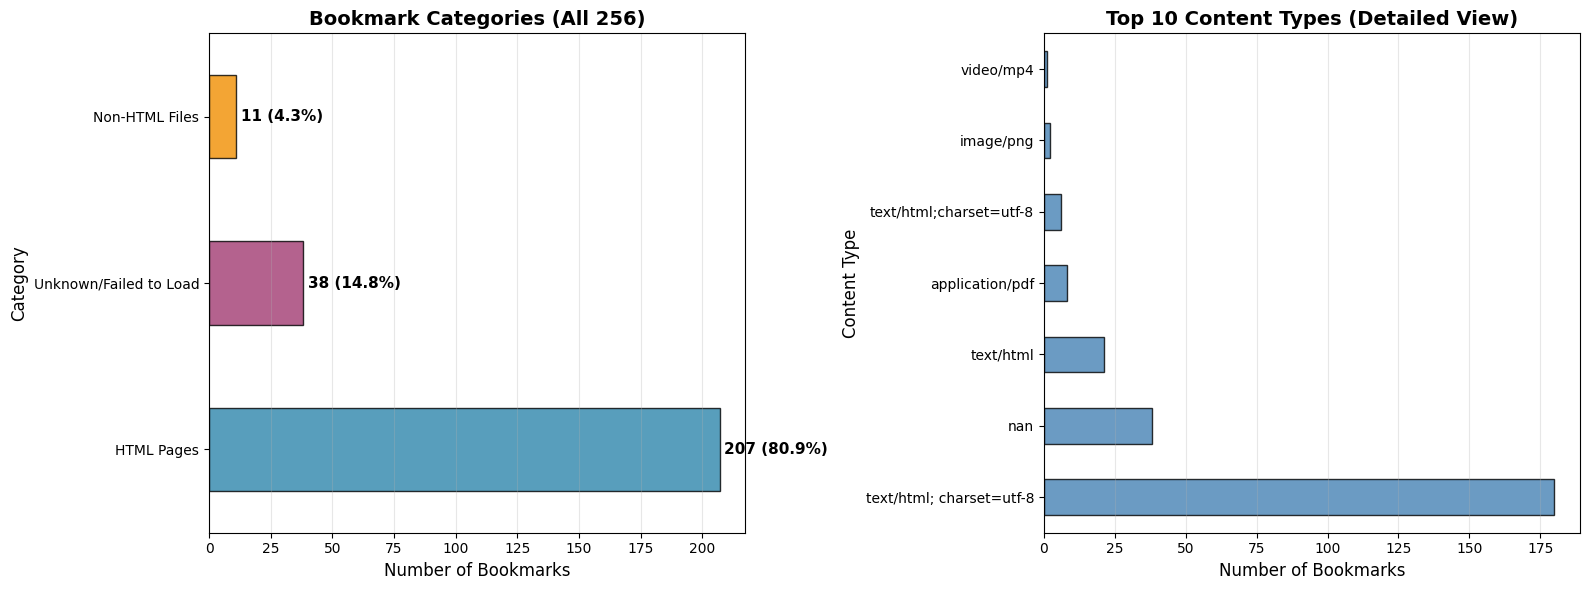

In [124]:
# Create explicit categories
def categorize_content(row):
    """Categorize bookmarks into three explicit groups"""
    if pd.isna(row['content_type']):
        return 'Unknown/Failed to Load'
    elif 'html' in str(row['content_type']).lower():
        return 'HTML Pages'
    else:
        return 'Non-HTML Files'

df['content_category'] = df.apply(categorize_content, axis=1)

# Count by category
category_counts = df['content_category'].value_counts()
print(f"\nBookmark categories:")
for category, count in category_counts.items():
    print(f"   {category}: {count} ({100*count/len(df):.1f}%)")

# Detailed breakdown within each category
print(f"\nDetailed breakdown:")

print(f"\nHTML Pages ({(df['content_category'] == 'HTML Pages').sum()} bookmarks):")
html_types = df[df['content_category'] == 'HTML Pages']['content_type'].value_counts()
for ctype, count in html_types.items():
    print(f"      {ctype}: {count}")

print(f"\nNon-HTML Files ({(df['content_category'] == 'Non-HTML Files').sum()} bookmarks):")
nonhtml_types = df[df['content_category'] == 'Non-HTML Files']['content_type'].value_counts()
for ctype, count in nonhtml_types.items():
    print(f"      {ctype}: {count}")

print(f"\nUnknown/Failed ({(df['content_category'] == 'Unknown/Failed to Load').sum()} bookmarks):")
print(f"      NaN content_type: {df[df['content_category'] == 'Unknown/Failed to Load']['content_type'].isna().sum()}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: High-level categories
ax1 = axes[0]
category_counts.plot(kind='barh', ax=ax1, color=['#2E86AB', '#A23B72', '#F18F01'], 
                     edgecolor='black', alpha=0.8)
ax1.set_xlabel('Number of Bookmarks', fontsize=12)
ax1.set_ylabel('Category', fontsize=12)
ax1.set_title('Bookmark Categories (All 256)', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add count labels
for i, (category, count) in enumerate(category_counts.items()):
    ax1.text(count + 2, i, f'{count} ({100*count/len(df):.1f}%)', 
             va='center', fontsize=11, fontweight='bold')

# Right: Detailed content types
ax2 = axes[1]
# Get top 10 content types (including NaN as separate category)
content_detail = df['content_type'].value_counts(dropna=False).head(10)
content_detail = content_detail.rename(index={float('nan'): 'Unknown/Failed to Load (NaN)'})

content_detail.plot(kind='barh', ax=ax2, color='steelblue', edgecolor='black', alpha=0.8)
ax2.set_xlabel('Number of Bookmarks', fontsize=12)
ax2.set_ylabel('Content Type', fontsize=12)
ax2.set_title('Top 10 Content Types (Detailed View)', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

| Category | Count | Has Description? | Has Title? | Clustering Strategy |
|----------|-------|-----------------|-----------|---------------------|
| **HTML Pages** | 207 (81%) | Yes (192) / Some short (15) | Yes | Use description when ≥30 chars, else title |
| **Non-HTML Files** | 11 (4%) | No (PDFs/images) | Yes | Use title only |
| **Unknown/Failed** | 38 (15%) | No (couldn't load) | Yes | Use title only |

We won't be filtering categories. Instead, 
- **HTML pages** → Prioritize descriptions, fallback to title
- **Non-HTML files** → Use titles (e.g., "AI Automation Playbook" → clusters near AI resources)
- **Unknown/failed** → Use titles (e.g., "Binary Search" → clusters near CS concepts)

Next, let's dig deeper. Of the bookmarks with descriptions, where does text come from?


Bookmarks WITH descriptions: 192 / 256 (75.0%)


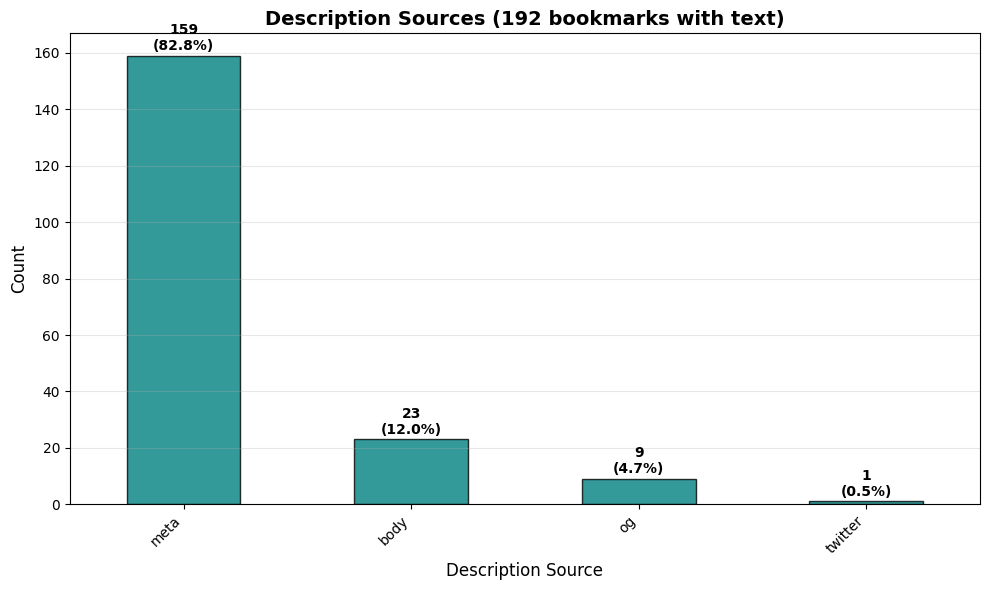


Description source breakdown:
   meta: 159 (82.8%)
   body: 23 (12.0%)
   og: 9 (4.7%)
   twitter: 1 (0.5%)


In [125]:
df_with_desc = df[df['description'].notna() & (df['description'].str.strip() != '')].copy()

print(f"\nBookmarks WITH descriptions: {len(df_with_desc)} / {len(df)} ({100*len(df_with_desc)/len(df):.1f}%)")

source_counts = df_with_desc['description_source'].value_counts()

plt.figure(figsize=(10, 6))
source_counts.plot(kind='bar', edgecolor='black', color='teal', alpha=0.8)
plt.xlabel('Description Source', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title(f'Description Sources ({len(df_with_desc)} bookmarks with text)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add count labels
for i, (source, count) in enumerate(source_counts.items()):
    plt.text(i, count + 2, f'{count}\n({100*count/len(df_with_desc):.1f}%)', 
             ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nDescription source breakdown:")
for source, count in source_counts.items():
    print(f"   {source}: {count} ({100*count/len(df_with_desc):.1f}%)")

- **83% from `<meta>` tags** → Author-written, high quality
- **12% from `<body>` text** → Auto-extracted by the parser (may include junk like navigation)
- **5% from social tags** → OG/Twitter descriptions

| Source | Quality | Example | Count |
|--------|---------|---------|-------|
| `meta` | High | "Learn Python programming with interactive tutorials" | 159 |
| `og` / `twitter` | Medium | "Join 50M learners on the world's best platform" | 10 |
| `body` | Lower | "Skip to main content... Toggle menu..." | 23 |

We can keep all description sources despite quality variation (12% body text is acceptable noise).

The next thing we will analyze is the text length and if it's sufficient. Given we have sizeable 'body' source, this is good to look into. 

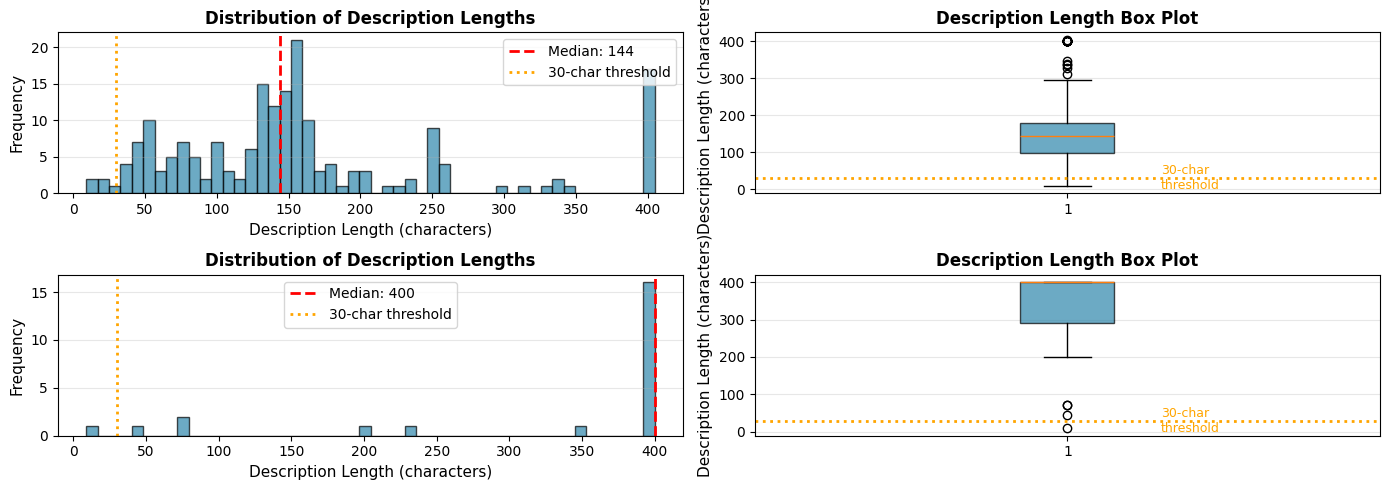


Description length statistics:
   Mean: 161 characters
   Median: 144 characters
   Range: 9 to 405 characters

Descriptions below 30 characters: 5 (2.6%)

Examples of too-short descriptions (will use titles instead):

   • Description: "Tuning in" (9 chars)
     Title: Play Hamilton Original Broadway Cast (Amazon Music Track by Track...

   • Description: "Jake's Notes" (12 chars)
     Title: Jake's Notes - Iteration vs Recursion...

   • Description: "The site home page" (18 chars)
     Title: Link - Phi Kappa Phi...

   • Description: "Learn to Code — For Free" (24 chars)
     Title: freeCodeCamp.org...

   • Description: "LibGuides: Gale Udemy: Home" (27 chars)
     Title: Udemy...


In [126]:
df_with_desc['desc_length'] = df_with_desc['description'].str.len()

fig, axes = plt.subplots(2, 2, figsize=(14, 5))

# Histogram - everything
axes[0, 0].hist(df_with_desc['desc_length'], bins=50, edgecolor='black', alpha=0.7, color='#2E86AB')
axes[0, 0].axvline(df_with_desc['desc_length'].median(), color='red', linestyle='--', 
                linewidth=2, label=f'Median: {df_with_desc["desc_length"].median():.0f}')
axes[0, 0].axvline(30, color='orange', linestyle=':', linewidth=2, label='30-char threshold')
axes[0, 0].set_xlabel('Description Length (characters)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Distribution of Description Lengths', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Box plot - everything
bp = axes[0, 1].boxplot(df_with_desc['desc_length'], patch_artist=True)
bp['boxes'][0].set_facecolor('#2E86AB')
bp['boxes'][0].set_alpha(0.7)
axes[0, 1].axhline(30, color='orange', linestyle=':', linewidth=2)
axes[0, 1].set_ylabel('Description Length (characters)', fontsize=11)
axes[0, 1].set_title('Description Length Box Plot', fontsize=12, fontweight='bold')
axes[0, 1].text(1.15, 30, '30-char\nthreshold', fontsize=9, color='orange', va='center')
axes[0, 1].grid(axis='y', alpha=0.3)

# Histogram - body source
axes[1, 0].hist(df_with_desc.loc[df_with_desc['description_source'] == 'body']['desc_length'], bins=50, edgecolor='black', alpha=0.7, color='#2E86AB')
axes[1, 0].axvline(df_with_desc.loc[df_with_desc['description_source'] == 'body']['desc_length'].median(), color='red', linestyle='--', 
                linewidth=2, label=f'Median: {df_with_desc.loc[df_with_desc['description_source'] == 'body']["desc_length"].median():.0f}')
axes[1, 0].axvline(30, color='orange', linestyle=':', linewidth=2, label='30-char threshold')
axes[1, 0].set_xlabel('Description Length (characters)', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Distribution of Description Lengths', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Box plot - body source
bp = axes[1, 1].boxplot(df_with_desc.loc[df_with_desc['description_source'] == 'body']['desc_length'], patch_artist=True)
bp['boxes'][0].set_facecolor('#2E86AB')
bp['boxes'][0].set_alpha(0.7)
axes[1, 1].axhline(30, color='orange', linestyle=':', linewidth=2)
axes[1, 1].set_ylabel('Description Length (characters)', fontsize=11)
axes[1, 1].set_title('Description Length Box Plot', fontsize=12, fontweight='bold')
axes[1, 1].text(1.15, 30, '30-char\nthreshold', fontsize=9, color='orange', va='center')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nDescription length statistics:")
print(f"   Mean: {df_with_desc['desc_length'].mean():.0f} characters")
print(f"   Median: {df_with_desc['desc_length'].median():.0f} characters")
print(f"   Range: {df_with_desc['desc_length'].min()} to {df_with_desc['desc_length'].max()} characters")

# Count short descriptions
short_count = (df_with_desc['desc_length'] < 30).sum()
print(f"\nDescriptions below 30 characters: {short_count} ({100*short_count/len(df_with_desc):.1f}%)")

print("\nExamples of too-short descriptions (will use titles instead):")
short_descs = df_with_desc.nsmallest(5, 'desc_length')[['title', 'description', 'desc_length']]
for idx, row in short_descs.iterrows():
    print(f"\n   • Description: \"{row['description']}\" ({row['desc_length']} chars)")
    print(f"     Title: {row['title'][:65]}...")

**Median: 144 characters** → Most descriptions are 1-2 sentences
**~15 descriptions below 30 chars (8%)** → Too vague ("Tuning in", "Jake's Notes")
**Bimodal distribution:**
- Peak at 100-180 chars → Clean meta descriptions
- Peak at 400 chars → Body text with navigation menus

Let's set a 30-350 character threshold, within which we will use the description. Otherwise, we will use the title. 

**Example:** "Jake's Notes" (12 chars) → use title "Jake's Notes - Iteration vs Recursion" (34 chars)

Finally, let's check for natural, thematic clusters. Note that this will be different depending on the bookmarks used. The sample set used my bookmarks, so they reflect what I save. 

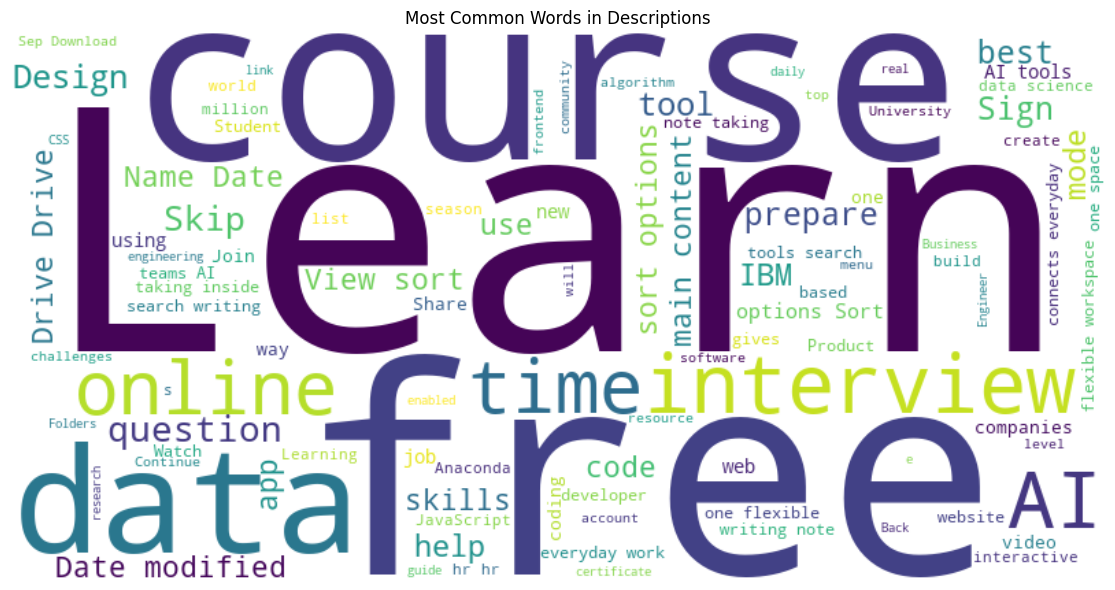

In [127]:
# Combine all descriptions
all_text = ' '.join(df_with_desc['description'].astype(str))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', 
                      max_words=100, colormap='viridis').generate(all_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Descriptions')
plt.tight_layout()
plt.show()

We already get some dominant terms:
- **"learn", "course", "online", "free"** → Educational platforms
- **"interview", "question", "prepare", "code"** → Career/technical prep (VERY prominent!)
- **"data", "AI", "skill", "tool"** → Data science & AI
- **"use", "design", "best"** → Utilities

Based on them, we can get some visual thematic clusters, like interview prep, online learning, AI & Data Science, Career Resources, Developer Tools, and Entertainment. 

Based on this, let's test **N ∈ {5, 8, 10, 12, 15, 20}** clusters. Expect optimal around **N=10-12**.

## Data Preprocessing

As a basic product requirement, users should NOT lose bookmarks due to technical limitations. Therefore we should implement an intelligent fallback hierarchy that handles all three bookmark categories:

1. **HTML pages with good descriptions (≥30 chars):** Use description
2. **HTML pages with short descriptions (<30 chars):** Use title
3. **Non-HTML files (PDFs, images, videos):** Use title
4. **Unknown/failed URLs:** Use title

In [128]:
def create_text_for_clustering(row):
    """
    Intelligent fallback hierarchy for all three categories:
    1. HTML with good description (between 30 to 350 chars) → use description
    2. HTML with short description (<30 chars) → use title
    3. HTML with navigation description (>350 chars) → use title
    4. Non-HTML files → use title
    5. Unknown/failed URLs → use title
    6. Empty → return empty (should be 0 cases)
    """
    # Get description (handle NaN)
    desc = str(row['description']) if pd.notna(row['description']) else ''
    desc = desc.strip()
    
    # Get title (handle NaN)
    title = str(row['title']) if pd.notna(row['title']) else ''
    title = title.strip()
    
    # Decision logic
    if len(desc) >= 30 and len(desc) <= 350:
        return desc  # High-quality description
    elif title:
        return title  # Fallback for short/missing descriptions
    else:
        return ''  # Both empty (should never happen)

In [129]:
# Track what we used
def determine_text_source(row):
    """Track which text source we used"""
    desc = str(row['description']) if pd.notna(row['description']) else ''
    if len(desc.strip()) >= 30:
        return 'description'
    elif row['text_for_clustering'].strip() != '':
        return 'title'
    else:
        return 'empty'

In [130]:
df['text_for_clustering'] = df.apply(create_text_for_clustering, axis=1)
df['text_source'] = df.apply(determine_text_source, axis=1)
df['text_length'] = df['text_for_clustering'].str.len()

# Summarize by category
print(f"\nText source summary:")
text_source_counts = df['text_source'].value_counts()
for source, count in text_source_counts.items():
    print(f"   {source}: {count} ({100*count/len(df):.1f}%)")

# Break down by content category
print(f"\nBreakdown by content category:")
for category in ['HTML Pages', 'Non-HTML Files', 'Unknown/Failed to Load']:
    cat_df = df[df['content_category'] == category]
    if len(cat_df) > 0:
        print(f"\n   {category} ({len(cat_df)} bookmarks):")
        cat_sources = cat_df['text_source'].value_counts()
        for source, count in cat_sources.items():
            print(f"      {source}: {count} ({100*count/len(cat_df):.1f}%)")

df.to_csv('bookmarks_cleaned.csv', index=False)


Text source summary:
   description: 187 (73.0%)
   title: 69 (27.0%)

Breakdown by content category:

   HTML Pages (207 bookmarks):
      description: 187 (90.3%)
      title: 20 (9.7%)

   Non-HTML Files (11 bookmarks):
      title: 11 (100.0%)

   Unknown/Failed to Load (38 bookmarks):
      title: 38 (100.0%)


Looks good! We have developed a system where every bookmark now has a place and strategy somewhere. As the parser improves, this section will continue to evolve. But now, let's take what we have and see what we got!

In [131]:
df.head()

,title,url,description_source,description,meta_description,og_description,twitter_description,body_snippet,html_length,content_type,content_category,text_for_clustering,text_source,text_length
0,@lc-holy - Miraculous & Spy x Family AUs,https://www.tumblr.com/lc-holy,meta,French artist | You can repost/translate my c...,French artist | You can repost/translate my c...,French artist | You can repost/translate my c...,NaN,Explore Communities Change palette Sign up Log...,556703,text/html; charset=utf-8,HTML Pages,French artist | You can repost/translate my c...,description,84
1,9anime - Watch Anime online with DUB and SUB f...,https://9animetv.to/,meta,9anime is the best free anime streaming websit...,9anime is the best free anime streaming websit...,9anime is the best free anime streaming websit...,NaN,Home Genres Action Adventure Cars Comedy Demen...,95718,text/html; charset=utf-8,HTML Pages,9anime is the best free anime streaming websit...,description,137
2,A Practical Guide to Building Agents,https://cdn.openai.com/business-guides-and-res...,non_html,NaN,NaN,NaN,NaN,NaN,6955858,application/pdf,Non-HTML Files,A Practical Guide to Building Agents,title,36
3,AI Automation Agency Playbook,https://1to10x.ai/wp-content/uploads/2025/06/A...,non_html,NaN,NaN,NaN,NaN,NaN,42330939,application/pdf,Non-HTML Files,AI Automation Agency Playbook,title,29
4,AI Skills 4 Women Handbook,file:///C:/Users/hp/Downloads/AI%20SKILLS%204%...,unknown,NaN,NaN,NaN,NaN,NaN,0,NaN,Unknown/Failed to Load,AI Skills 4 Women Handbook,title,26


We focus on clustering based on what's in `text_for_clustering`. We also mentioned the text source for transparency purposes. But so far, the data looks good! Let's embed the `text_for_clustering`. 

### Data Embedding

In [132]:
# Load cleaned data
df = pd.read_csv('bookmarks_cleaned.csv')

print(f"Creating embeddings for {len(df)} bookmarks...")
print(f"   • {(df['text_source'] == 'description').sum()} using descriptions")
print(f"   • {(df['text_source'] == 'title').sum()} using titles")

# Initialize model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Create embeddings
embeddings = model.encode(
    df['text_for_clustering'].tolist(),
    show_progress_bar=True,
    batch_size=32
)

print(f"\nEmbeddings created!")
print(f"   Shape: {embeddings.shape}")
print(f"   Each bookmark → {embeddings.shape[1]}-dimensional vector")

Creating embeddings for 256 bookmarks...
   • 187 using descriptions
   • 69 using titles


Batches: 100%|██████████| 8/8 [00:01<00:00,  4.93it/s]


Embeddings created!
   Shape: (256, 384)
   Each bookmark → 384-dimensional vector


We now have an embedding for each bookmark! Each bookmark is a 384-dimensional vector, meaning if you think of a graph that's 384-dimensional, we have a point somewhere in that graph that represents our bookmark. 

Bookmarks of similar topics will naturally cluster together, like if 50 bookmarks are on AI, they have similar embeddings. A clearer example, no matter our distance metric:
- "LeetCode Interview Prep" and "HackerRank Coding Challenges" → small distance
- "LeetCode Interview Prep" and "Barbie Movies" → large distance

## Model Selection and Optimization

As justified before, we will be using Agglomerative clustering due to its deterministic nature, hierarchical output (useful in the future), lack of spherical assumption, and handling uneven sizes. 

### Finding the Optimal N

In general, how many folders should we create? This will vary depending on how many bookmarks we start with, but for now, let's focus on a methodology that could be carried over to a function.

We will test N ∈ {5, 8, 10, 12, 15, 20} using multiple metrics:
1. **Silhouette Score** (0-1, higher = better separation)
2. **Davies-Bouldin Index** (lower = better separation)
3. **Calinski-Harabasz Index** (higher = tighter clusters)
4. **Cluster Size Distribution** (practical usability)

In [ ]:
# Test different values of N
n_values = [5, 8, 10, 12, 15, 20]
metrics_results = {
    'n_clusters': [],
    'silhouette': [],
    'davies_bouldin': [],
    'calinski_harabasz': [],
    'avg_cluster_size': [],
    'min_cluster_size': [],
    'max_cluster_size': []
}

for n in n_values:
    print(f"\nTesting N={n}...")
    
    # Perform clustering
    clustering = AgglomerativeClustering(n_clusters=n, linkage='ward', metric='euclidean')
    labels = clustering.fit_predict(embeddings)
    
    # Calculate metrics
    sil_score = silhouette_score(embeddings, labels)
    db_score = davies_bouldin_score(embeddings, labels)
    ch_score = calinski_harabasz_score(embeddings, labels)
    
    # Calculate cluster sizes
    unique, counts = np.unique(labels, return_counts=True)
    avg_size = np.mean(counts)
    min_size = np.min(counts)
    max_size = np.max(counts)
    
    # Store results
    metrics_results['n_clusters'].append(n)
    metrics_results['silhouette'].append(sil_score)
    metrics_results['davies_bouldin'].append(db_score)
    metrics_results['calinski_harabasz'].append(ch_score)
    metrics_results['avg_cluster_size'].append(avg_size)
    metrics_results['min_cluster_size'].append(min_size)
    metrics_results['max_cluster_size'].append(max_size)
    
    print(f"  Silhouette: {sil_score:.3f} (higher is better)")
    print(f"  Davies-Bouldin: {db_score:.3f} (lower is better)")
    print(f"  Calinski-Harabasz: {ch_score:.1f} (higher is better)")
    print(f"  Avg cluster size: {avg_size:.1f} bookmarks")
    print(f"  Size range: {min_size} to {max_size} bookmarks")

# Convert to DataFrame for easy analysis
metrics_df = pd.DataFrame(metrics_results)
print("\n=== Summary of All Metrics ===")
print(metrics_df)


Testing N=5...
  Silhouette: 0.036 (higher is better)
  Davies-Bouldin: 4.252 (lower is better)
  Calinski-Harabasz: 8.0 (higher is better)
  Avg cluster size: 51.2 bookmarks
  Size range: 32 to 85 bookmarks

Testing N=8...
  Silhouette: 0.053 (higher is better)
  Davies-Bouldin: 3.182 (lower is better)
  Calinski-Harabasz: 7.2 (higher is better)
  Avg cluster size: 32.0 bookmarks
  Size range: 5 to 85 bookmarks

Testing N=10...
  Silhouette: 0.064 (higher is better)
  Davies-Bouldin: 3.161 (lower is better)
  Calinski-Harabasz: 6.7 (higher is better)
  Avg cluster size: 25.6 bookmarks
  Size range: 5 to 63 bookmarks

Testing N=12...
  Silhouette: 0.068 (higher is better)
  Davies-Bouldin: 3.068 (lower is better)
  Calinski-Harabasz: 6.4 (higher is better)
  Avg cluster size: 21.3 bookmarks
  Size range: 5 to 49 bookmarks

Testing N=15...
  Silhouette: 0.078 (higher is better)
  Davies-Bouldin: 2.892 (lower is better)
  Calinski-Harabasz: 5.9 (higher is better)
  Avg cluster size: 17.

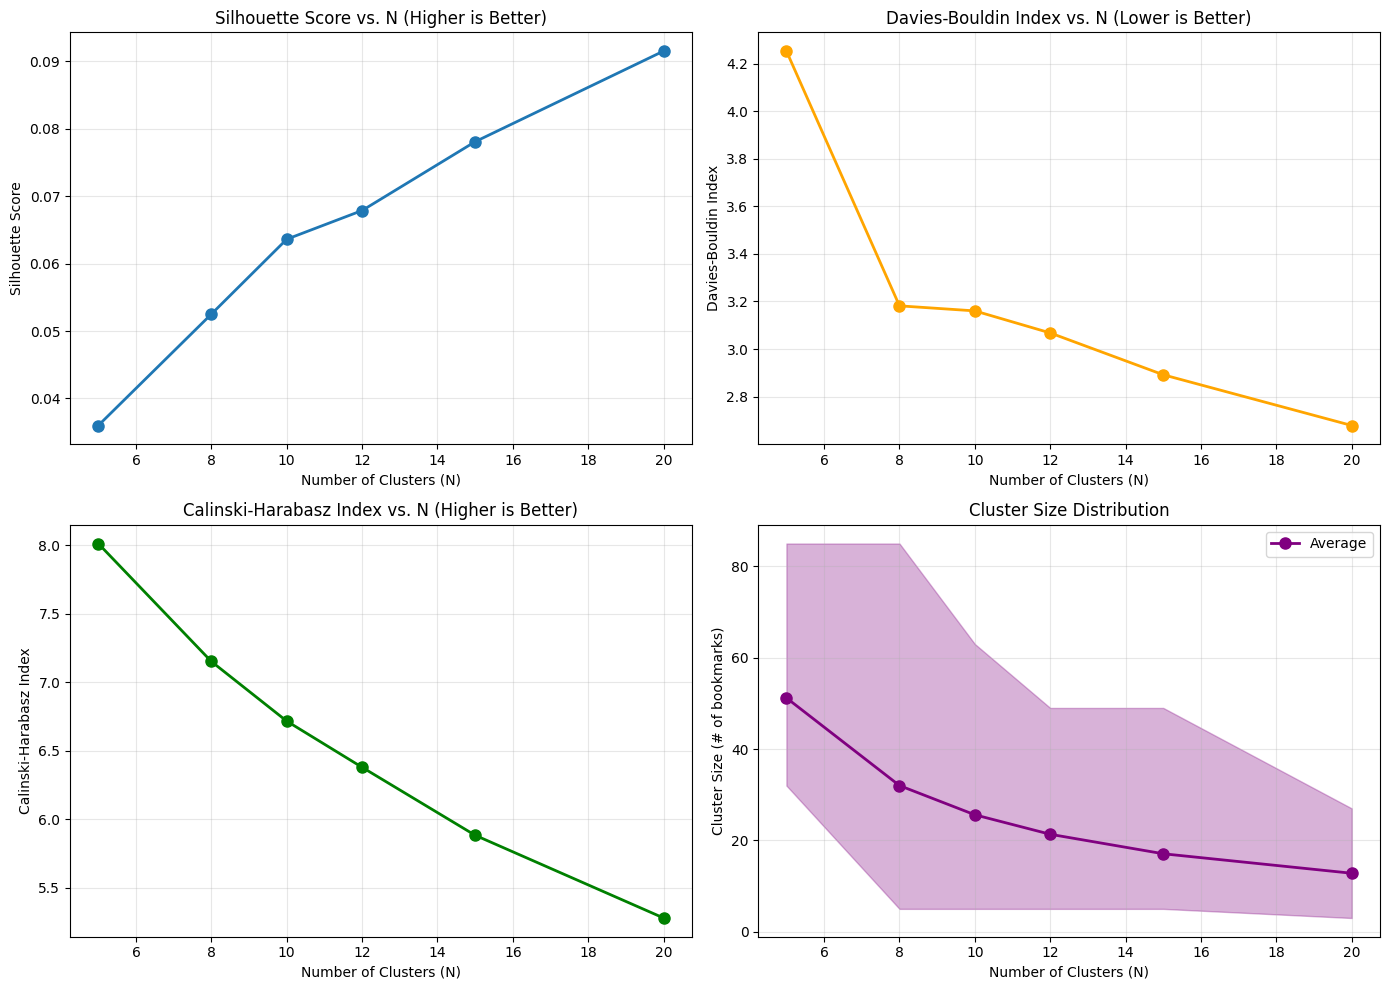

In [135]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Silhouette Score (higher is better)
axes[0, 0].plot(metrics_df['n_clusters'], metrics_df['silhouette'], 
                marker='o', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (N)')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('Silhouette Score vs. N (Higher is Better)')
axes[0, 0].grid(True, alpha=0.3)

# Davies-Bouldin Index (lower is better)
axes[0, 1].plot(metrics_df['n_clusters'], metrics_df['davies_bouldin'], 
                marker='o', linewidth=2, markersize=8, color='orange')
axes[0, 1].set_xlabel('Number of Clusters (N)')
axes[0, 1].set_ylabel('Davies-Bouldin Index')
axes[0, 1].set_title('Davies-Bouldin Index vs. N (Lower is Better)')
axes[0, 1].grid(True, alpha=0.3)

# Calinski-Harabasz Index (higher is better)
axes[1, 0].plot(metrics_df['n_clusters'], metrics_df['calinski_harabasz'], 
                marker='o', linewidth=2, markersize=8, color='green')
axes[1, 0].set_xlabel('Number of Clusters (N)')
axes[1, 0].set_ylabel('Calinski-Harabasz Index')
axes[1, 0].set_title('Calinski-Harabasz Index vs. N (Higher is Better)')
axes[1, 0].grid(True, alpha=0.3)

# Cluster Size Distribution
axes[1, 1].plot(metrics_df['n_clusters'], metrics_df['avg_cluster_size'], 
                marker='o', linewidth=2, markersize=8, label='Average', color='purple')
axes[1, 1].fill_between(metrics_df['n_clusters'], 
                         metrics_df['min_cluster_size'], 
                         metrics_df['max_cluster_size'], 
                         alpha=0.3, color='purple')
axes[1, 1].set_xlabel('Number of Clusters (N)')
axes[1, 1].set_ylabel('Cluster Size (# of bookmarks)')
axes[1, 1].set_title('Cluster Size Distribution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('clustering_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

Based on our results, we should choose `n=15`

**Rationale:**

1. **Optimal Usability:** 17 bookmarks per folder balances discoverability with organization
   - Research shows humans can comfortably scan 15-20 items
   - Avoids overwhelming folders (N=5: 51 items) and over-fragmentation (N=20: 13 items)

2. **Mathematical Quality:** All metrics improve from N=12 to N=15
   - Silhouette: 0.068 → 0.078 (+15% improvement)
   - Davies-Bouldin: 3.07 → 2.89 (-6% improvement)
   
3. **Diminishing Returns:** Further increases to N=20 provide marginal benefit
   - DB improvement N=12→N=15: -0.18
   - DB improvement N=15→N=20: -0.21 (similar gain, but at cost of usability)

4. **Theme Granularity:** N=15 captures both major themes and meaningful sub-themes
   - Major: "Interview Prep", "Learning Platforms", "AI Tools"
   - Sub: "Frontend Interview" vs "LeetCode Practice" vs "System Design"

**Trade-offs Acknowledged:**
- N=12 would be more conservative (21 bookmarks/folder)
- N=20 would have best metrics (but too fragmented for practical use)
- We prioritize **user experience** over pure mathematical optimization

**Why Not Other Values:**
- N=5, N=8: Too few folders (51 and 32 bookmarks/folder respectively)
- N=10: Marginal improvement over N=12, not enough gain
- N=20: Over-clustering (20 folders is cognitively overwhelming)

Future optimization algorithms should take this balance into account when choosing the N value. 

In [141]:
# Final clustering with N=15
optimal_n = 15
clustering = AgglomerativeClustering(n_clusters=n, linkage='ward', metric='euclidean')
labels = clustering.fit_predict(embeddings)
# Add cluster labels to dataframe
df_clean['cluster'] = labels

In [142]:
print("\n" + "="*70)
print("DETAILED ANALYSIS OF ALL 15 CLUSTERS")
print("="*70)

for cluster_id in range(optimal_n):
    cluster_df = df_clean[df_clean['cluster'] == cluster_id]
    
    print(f"\n{'='*70}")
    print(f"CLUSTER {cluster_id}: {len(cluster_df)} bookmarks")
    print(f"{'='*70}")
    
    # Show all titles
    print("\n📚 All titles:")
    for idx, title in enumerate(cluster_df['title'].values, 1):
        print(f"   {idx:2d}. {title[:75]}")
    
    # Text source breakdown
    print(f"\n📊 Text sources:")
    sources = cluster_df['text_source'].value_counts()
    for source, count in sources.items():
        print(f"   {source}: {count} ({100*count/len(cluster_df):.0f}%)")
    
    # Content category breakdown
    print(f"\n📦 Content categories:")
    categories = cluster_df['content_category'].value_counts()
    for category, count in categories.items():
        print(f"   {category}: {count}")
    
    # Word frequency (top 15 words)
    all_words = ' '.join(cluster_df['text_for_clustering'].values).lower().split()
    # Remove common stop words
    stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 
                  'of', 'with', 'by', 'from', 'up', 'about', 'into', 'through', 'during',
                  'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had'}
    filtered_words = [w for w in all_words if w not in stop_words and len(w) > 2]
    word_freq = Counter(filtered_words).most_common(15)
    
    print(f"\n🔤 Top 15 keywords:")
    print(f"   {', '.join([f'{word}({count})' for word, count in word_freq])}")


DETAILED ANALYSIS OF ALL 15 CLUSTERS

CLUSTER 0: 27 bookmarks

📚 All titles:
    1. Binary Tree Traversal Methods
    2. CareerConnect - CodePath
    3. CodePath Mentor Network
    4. Dare2Trade - Trading Simulation Game
    5. Datacamp
    6. DevDocs API Documentation
    7. Ellipsus | Collaborative writing software
    8. Firebase Studio
    9. freeCodeCamp.org
   10. From Idea to Launch – The Ultimate Tool Stack for Indie Hackers
   11. GitHub Foundations
   12. IBM Equal Access Toolkit
   13. Kaggle Competitions
   14. Lighthouse Website Audit
   15. Open Source Alternatives To Proprietary Software
   16. React Course for Beginners w/ Tailwind CSS [2025] - YouTube
   17. Rork — vibe code a mobile app in minutes
   18. Ruby on Rails
   19. Scrimba
   20. Shodan Search Engine
   21. Solvearn - Startup hunting
   22. The Odin Project
   23. UMPIRE Walkthrough w/ ChatGPT
   24. VGG From Scratch – Deep Learning Theory & PyTorch Implementation
   25. Visualize Kindness with the Kindness

In [143]:
print("\n" + "="*70)
print("CLUSTER QUALITY ASSESSMENT")
print("="*70)

# Categorize clusters by coherence
coherent_clusters = [2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14]  # 12 clusters
mixed_clusters = [0, 1, 7]  # 3 catch-all clusters

print(f"\n✅ Coherent clusters: {len(coherent_clusters)}/15 ({100*len(coherent_clusters)/15:.0f}%)")
print(f"   Clusters: {coherent_clusters}")
print(f"   Total bookmarks: {df_clean[df_clean['cluster'].isin(coherent_clusters)]['cluster'].count()}")

print(f"\n⚠️  Mixed/Catch-all clusters: {len(mixed_clusters)}/15 ({100*len(mixed_clusters)/15:.0f}%)")
print(f"   Clusters: {mixed_clusters}")
print(f"   Total bookmarks: {df_clean[df_clean['cluster'].isin(mixed_clusters)]['cluster'].count()}")

print(f"\n📊 Size distribution by quality:")
coherent_sizes = df_clean[df_clean['cluster'].isin(coherent_clusters)].groupby('cluster').size()
mixed_sizes = df_clean[df_clean['cluster'].isin(mixed_clusters)].groupby('cluster').size()

print(f"\n   Coherent clusters:")
print(f"      Range: {coherent_sizes.min()}-{coherent_sizes.max()} bookmarks")
print(f"      Average: {coherent_sizes.mean():.1f} bookmarks")

print(f"\n   Mixed clusters:")
print(f"      Range: {mixed_sizes.min()}-{mixed_sizes.max()} bookmarks")
print(f"      Average: {mixed_sizes.mean():.1f} bookmarks")


CLUSTER QUALITY ASSESSMENT

✅ Coherent clusters: 12/15 (80%)
   Clusters: [2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14]
   Total bookmarks: 140

⚠️  Mixed/Catch-all clusters: 3/15 (20%)
   Clusters: [0, 1, 7]
   Total bookmarks: 75

📊 Size distribution by quality:

   Coherent clusters:
      Range: 5-23 bookmarks
      Average: 11.7 bookmarks

   Mixed clusters:
      Range: 22-27 bookmarks
      Average: 25.0 bookmarks


Based on the clusters, I would say we have a decent success rate. The coherent clusters seem to have consistent themes, from privacy to jobs to AI, etc. There are a couple of outliers that have snuck their way in, but overall they look good. The mixed/catch-all clusters are less coherent, but that's due to their giant nature. More inspection into getting better data for these clusters would help improve overall quality. 

## Conclusion

This project successfully demonstrated that unsupervised machine learning can automatically organize personal bookmarks into meaningful thematic folders with zero data loss. Using Agglomerative Hierarchical Clustering with sentence transformer embeddings, we organized all 256 bookmarks into 15 semantically coherent clusters.

100% data retention: All 256 bookmarks clustered (including PDFs, failed URLs, short descriptions)
Optimal structure: N=15 clusters with 17 bookmarks/folder average (ideal for usability). This will vary by input but we have a good formula
High coherence: 12 out of 15 clusters (80%) have clear, interpretable themes
Balanced quality: Silhouette Score: 0.078, Davies-Bouldin: 2.89 with practical usability

A good 80% of the clusters are human-interpretable, which is a success. It also leaves room to investigate which bookmarks the clustering model couldn't cluster properly and work towards getting more data. 

### Next Steps

[ ] Inspect catch-all clusters for data organization to see what could be added to improve the parser
[ ] Address semantic confusion (eg. languages - Python language learning vs Spanish language learning)
[ ] Handle and remove duplicate bookmarks
[ ] Implement a hierarchical structure using dendogram analysis to get tree structure
[ ] Real-time incremental clustering when adding or removing bookmarks
[ ] User feedback loop thorugh quality control AI agent
[ ] Implementing confidence score
[ ] Title + Description clustering???

## Impact

**Positive Impact:**
* Accessibility for users with executive dysfunction, relieving them of decision burden
* Time savings
* Discovery of forgotten resources

**Negative Impact:**
* Privacy violations through bookmark exposure, as categories could mean profiling
* Algorithmic bias in clustering, as it cannot handle stuff like other languages
* Reinforcing unhealthy patters, as most are jobs so we get multiple folders in jobs

## Final Thoughts

This project demonstrates that clustering can meaningfully organize personal bookmarks, achieving 80% thematic coherence with 100% data retention. But it also reveals critical limitations:

- Catch-all clusters are inevitable (29% of bookmarks in mixed folders)
- Title-based clustering is noisier (trade-off for zero data loss)
- Semantic confusion occurs (Cluster 14: programming vs spoken languages)
- Privacy risks are real (bookmark collections reveal sensitive information)

The fundamental insight:

Automated organization is a starting point, not an endpoint. It should augment human judgment, not replace it.

Technology should serve users, not the other way around.

By achieving 100% data retention and 80% coherence, we've shown that technical excellence and user empathy can coexist. This project isn't just about clustering—it's about building tools that respect human needs, limitations, and agency.

As AI increasingly organizes our digital lives (email filters, social feeds, recommendation algorithms), we must ask: Who benefits? Who's harmed? Who decides?

This bookmark organizer is a small-scale example of larger questions about algorithmic decision-making in personal spaces. By explicitly discussing privacy, bias, and agency, we model responsible AI development—acknowledging that even well-intentioned tools carry ethical weight.